In [ ]:
# !pip install onnx
# !pip install onnxruntime
import torch
import torch.onnx
import torchvision
import onnxruntime
import onnx
import matplotlib.pyplot as plt

In [ ]:
class ONNX_Inference:
  ''' Running onnx model on ORT 
      Attributes:
        onnx_path: path to .onnx file
  '''

  def __init__(self, onnx_path):
    self.dummy_input = torch.zeros((3, 256, 256)).to('cuda')
    self.onnx_path = onnx_path
  
  def _to_standart_format(self, image):
    ''' transform image to standart format '''

    if image.shape[1] > 256:
      image = torchvision.transforms.Resize(256)(image)
    elif image.shape[1] < 256:
      image = torchvision.transforms.Pad(256-image.shape[1])(image)
    
    if torch.max(image) > 1:
      image = image/255
    
    if image.shape[0] == 1:
      image = torch.cat([image, image, image])

    return image.unsqueeze(0)
  
  def run_onnx(self, image):
    image = torchvision.io.read_image(image)
    image = self._to_standart_format(image)

    sess = onnxruntime.InferenceSession(self.onnx_path)
    input_name = sess.get_inputs()[0].name
    pred = sess.run(None, {input_name: image.numpy()})

    return pred[0]
  
  def run_show_image(self, image):
    onnx_out = self.run_onnx(image)
    mask = torch.from_numpy(onnx_out[0])
    input_size = 256

    img = torchvision.io.read_image(image)
    if img.shape[1] > input_size:
      img = torchvision.transforms.Resize(input_size)(img)
    elif img.shape[1] < input_size:
      img = torchvision.transforms.Pad(input_size-img.shape[1])(img)
    
    if img.shape[0] == 1:
      img = torch.cat([img, img, img])
    
    masked_image = torchvision.utils.draw_segmentation_masks(img, (mask > 0.9), colors=['red'])

    plt.imshow(masked_image.permute(1,2,0))

In [ ]:
lung_onnx = ONNX('/content/lung_seg_onnx.onnx')

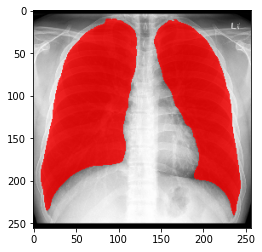

In [ ]:
lung_onnx.run_show_image('/content/332aa0c67cb2e035e372c7cb3ceca2_jumbo.jpg')